In [58]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [59]:
def solution(x, t, m, C):
    alpha = 1.0 / (m + 1)
    factor = t**(-alpha)
    inner = C - (m - 1) / (2 * m * (m + 1)) * x**2 / (t**(2 * alpha))
    return factor * np.maximum(inner, 0)**(1.0 / (m - 1))

In [60]:
L = 15.0 
T = 1.0
Q0 = 1
alpha = 1
omega = 0.1
m = 2
C = 1

In [61]:
def pde_porous_medium(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=2)
    u_xx = dde.grad.hessian(u,x,i=0,j=0)
    u_yy = dde.grad.hessian(u,x,i=0,j=1)

    return u_t - alpha*(u_xx + u_yy) - Q0*torch.cos(omega*x[:,2:3])



geom = dde.geometry.Rectangle(xmin=[0,0], xmax=[L,L])
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(x, on_boundary):
    return on_boundary


# условия нулевые на достаточно далеком иксе
bc_x= dde.DirichletBC(
    geomtime,
    lambda x: 0.0,           
    boundary,
    component= 0
   
)





def on_initial(x, on_initial):
    return on_initial 

def ic_func(x):
                   
    return 0

ic = dde.IC(geomtime, ic_func, on_initial)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde_porous_medium,
    [bc_x,ic],
    num_domain=10000,
    num_boundary=500,
    num_initial=500,
)

net = dde.nn.FNN(
    [3] + [20] * 2 + [1],  
    "tanh",
    "Glorot normal",
)

In [62]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train(iterations=10000,callbacks=[resampler])
model.compile('L-BFGS')

losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000297 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.76e-01, 4.78e-01, 2.39e-01]    [9.76e-01, 4.78e-01, 2.39e-01]    []  


KeyboardInterrupt: 

Text(0.5, 0.92, 'PINN solution')

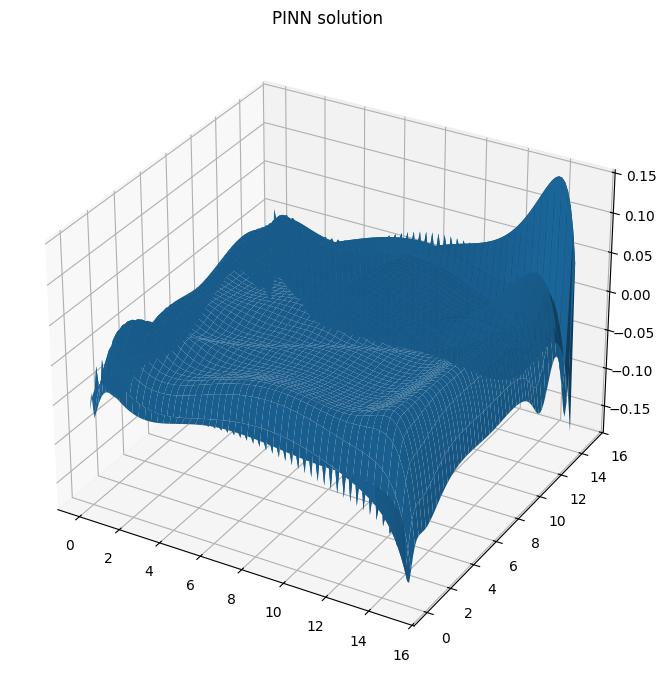

In [ ]:
x = np.linspace(0, L, 100)
y = np.linspace(0, L,100)
X,Y = np.meshgrid(x,y)
XY = np.vstack((X.ravel(), Y.ravel(), np.zeros_like(Y.ravel()))).T
U_pinn   = model.predict(XY).reshape(100, 100)
fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(1,2,1, projection = '3d')
ax.plot_surface(X,Y,U_pinn)
ax.set_title('PINN solution')
